Author: **Hanzhi Helen Tan**


Instruction
https://docs.google.com/document/d/1cPEFea88Y9mvyNGhXVRphjLTzmFlkM7ODpBWhdmUVvI/edit

Task: create transmission spectra, and model to regress on the H20 gas mixing ratio based on the spectra

## Import

In [9]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.constants import G, M_sun
import pytmosph3r as p3
import exo_k as xk
from pathlib import Path
import os
import EPOS
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch Data & Sanity Check
In this section, I found the correct data source and set up the directory used for pytmosph3r simulation. 
Data source: https://forge.oasu.u-bordeaux.fr/amechineau/pytmosph3r-data/-/tree/minimal?ref_type=heads

In [3]:
# # Create directory structure
# !mkdir -p data/corrk data/cia data/aerosol data/xsec data/gcm_output data/chemistry
# # Fetch data
# !wget -P data/corrk/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/corrk_gcm_IR.dat
# !wget -P data/corrk/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/corrk_gcm_VI.dat
# !wget -P data/gcm_output/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/log_IR.out
# !wget -P data/gcm_output/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/log_VI.out
# !wget -P data/xsec/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/narrowbands_IR.in
# !wget -P data/xsec/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/narrowbands_VI.in

# # Note: The actual URLs provided above might not be directly downloadable via wget in a real scenario
# # due to potential access restrictions or the need for authentication.
# # The provided commands assume direct access is available.


In [155]:
from pathlib import Path

# Path where the data are stored
data_path: Path = Path('/Users/hanzhitan/Desktop/gsoc') / 'data'

xsec_path = (data_path / "corrk").as_posix()
aerosol_path = (data_path / "aerosol").as_posix()
cia_path = (data_path / "cia").as_posix()
xk.Settings().set_search_path(xsec_path)
xk.Settings().set_cia_search_path(cia_path)
xk.Settings().set_aerosol_search_path(aerosol_path)
#xk.Settings().set_delimiter(".")
xk.Settings().set_mks(True) 
xk.Settings().set_log_interp(False)

In [26]:
Rp = 1.807 * 6.9911e7 * u.Unit('m')
g0 = 6.67384e-11 * 1.183 * 1.898e27 / Rp**2 * u.Unit('m3*s-2')


orbit=p3.CircularOrbit(a=1.*u.au)
planet = p3.Planet(surface_gravity=g0, radius=Rp)
star = p3.Star.fromSolar(temperature=6460.0, radius=1.458) # radius is in sun radii
grid = p3.Grid3D(n_vertical=100, n_latitudes=1, n_longitudes=1)
input_atmosphere = p3.InputAtmosphere(grid=grid,

     # Feel free to add a 1D temperature profile here instead
     temperature = 2000,

     # bottom and top pressures
     max_pressure = 1e6, min_pressure = 1e-4,

     # Again, you could add more complex molecular profiles if needed
     gas_mix_ratio = {"H2O":5.01187234e-01, #ratio to simulate
                      "H2":"background"
                     },
     # molecules for which we will not compute the opacity
     transparent_gases = "H2")
observer = p3.Observer(0, 180) # latitude, longitude in degrees
rays = p3.Rays(n_radial=100, n_angular=1) # in 1D cases, only 1 angle is required
opacity = p3.Opacity(rayleigh=True, cia=['H2', 'H2O'])


In [27]:
model = p3.Model(n_vertical = 100,
                 planet=planet,
                 star=star,
                 orbit=orbit,
                 observer=observer,
                 input_atmosphere=input_atmosphere,
                 transmission=p3.Transmission(rays=rays),
                 opacity=opacity,)

model.build()

pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126329177.0
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7670393470598107
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.389650117079357
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_sol = 0.9999999999999999
pytmosph3r.Model - INFO - Setting star.radius = 1014330600.0
pytmosph3r.Model - INFO - Setting star.radius_sol = 1.458
pytmosph3r.Model - INFO - Setting star.temperature = 6460.0
pytmosph3r.Model - INFO - Setting star.verbose = 0
pytmosph3r.Model - INFO - Setting input_atmosphere.aerosols (le

In [30]:
model.run()
plot = p3.Plot(model=model, label="1D", interactive=True, out_folder="outputs")
plot.plot_spectrum()

pytmosph3r.Model - INFO - Running model...
pytmosph3r.Opacity - INFO - Exo_k: Loading gas database for ['H2O']... (H2 considered transparent)


be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE


Saved to `outputs/spectrum_pytmosph3r.pdf`


## Data Simulation

* in terms of the **mass and orbit** distribution of transit planet, I decided to ignore the observational bias and refer to https://iopscience.iop.org/article/10.3847/1538-4357/ab5187 / Exoplanet Population Observation Simulator for the model. I use Kepler DR25 for the real world distribution, and Monte-Carlo method for the simulation.

### Period & Radii Data
days vs size of earth -> meter


 |~| epos 3.0.2 |~|

Initializing 'example_1'

Using random seed 3604974129
Survey: None selected

Loading planets from temp/q1_q17_dr25_koi.npz
  6853/7995 dwarfs
  3525 candidates, 3328 false positives
  3040+1 with score > 0.90

Observations:
  159238 stars
  3041 planets

  1840 singles, 487 multis
  - single: 1840
  - double: 324
  - triple: 113
  - quad: 38
  - quint: 10
  - sext: 2


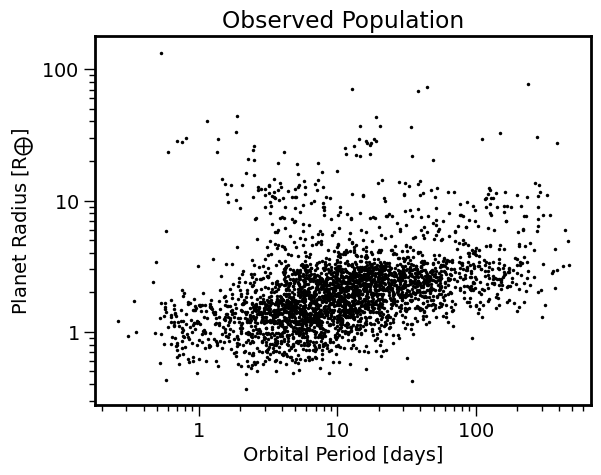

In [3]:
##distribution of the observed data
%matplotlib inline
epos= EPOS.epos(name='example_1')
obs, survey= EPOS.kepler.dr25(Huber=True, Vetting=True, score=0.9)
epos.set_parametric(EPOS.fitfunctions.brokenpowerlaw2D)
epos.set_survey(**survey)
epos.set_observation(**obs)
EPOS.plot.survey.observed(epos, NB=True, PlotBox=False)

In [4]:
epos.fitpars.add('pps',             2.0,    min=0,                  isnorm=True)

epos.fitpars.add('P break', 10.,    min=2,  max=50, is2D=True)
epos.fitpars.add('a_P',             1.5,    min=0,                  is2D=True)
epos.fitpars.add('b_P',             0.0,    dx=0.1,                 is2D=True)
epos.fitpars.add('R break', 3.0,    min=1.0,max=5,  is2D=True)
epos.fitpars.add('a_R',             0.0,    dx=0.1,                 is2D=True)
epos.fitpars.add('b_R',             -4.,    fixed=True,     is2D=True)
epos.set_ranges(xtrim=[0,730],ytrim=[0.3,20.],xzoom=[2,400],yzoom=[1,6], Occ=True)
EPOS.run.once(epos)
EPOS.run.mcmc(epos, nMC=5000, nwalkers=100, nburn=200, threads=20, Saved=True)
epos.set_bins(xbins=[[2,400],[0.9*365,2.2*365]], ybins=[[1,6],[0.7,1.5]]) # eta_zoom, eta_earth
EPOS.occurrence.all(epos)


Preparing EPOS run...
  6 fit parameters

Starting the first MC run
Finished one MC in 0.054 sec

Loading saved status from chain/example_1/100x5000x6.npz

NOTE: Random seed changed: 687655369 to 3604974129

MC-ing the 30 samples to plot

Best-fit values
  pps= 4.7 +1.53 -1.22
  P break= 12.4 +4.98 -3.35
  a_P= 1.6 +0.556 -0.258
  b_P= 0.247 +0.121 -0.2
  R break= 3 +0.167 -0.179
  a_R= -0.395 +0.249 -0.216

Starting the best-fit MC run

Goodness-of-fit
  logp= -1.7
  - p(n=2335)=1
  - p(x)=0.42
  - p(y)=0.43

  Akaike/Bayesian Information Criterion
  - k=6, n=2336
  - BIC= 49.9
  - AIC= 15.4, AICc= 0.6
  observation comparison in 0.004 sec

Interpolating planet occurrence

  Observed Planets
  x: [2,400], y: [1,6], n=2336, comp=0.037, occ=1.1
  x: [328,803], y: [0.7,1.5], n=0, comp=nan, occ=0

  x zoom bins
  x: [2,400], y: [0.25,0.32], n=0, comp=nan, occ=0
  x: [2,400], y: [0.32,0.41], n=1, comp=0.0011, occ=0.0055
  x: [2,400], y: [0.41,0.53], n=8, comp=0.002, occ=0.82
  x: [2,400],

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  gamma= 13.6% +2.3% -2.3%
  eta= 129.1% +22.0% -21.7%
  x: [328,803], y: [0.7,1.5], area=0.68, eta_0=0.1
  gamma= 51.6% +21.5% -21.5%
  eta= 35.2% +14.7% -14.6%

  Binned occurrence rate metrics
  x: (n=12, k=6)
    chi^2= 174.4, reduced= 29.1
    bic= 47.0
    aic= 73.9, AICc= 1242.1
  y: (n=7, k=6)
    chi^2= 157.0, reduced= 157.0
    bic= 33.4
    aic= 47.4, AICc= inf


/opt/anaconda3/lib/python3.11/site-packages/EPOS/analytics.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  cfactor= (2.* k_free**2. + 2.*k_free) / (n_data- k_free - 1.)


In [5]:
print(epos.synthetic_survey)
epos.synthetic_survey['P'].shape

{'P': array([  9.40419719,  36.6125478 ,  16.78788205, ...,  32.10170404,
         1.59758002, 158.53334341]), 'Y': array([1.81386022, 1.36020776, 1.17533192, ..., 1.27792703, 0.54257975,
       1.94724578]), 'P zoom': array([  9.40419719,  36.6125478 ,  16.78788205, ...,   7.65703797,
        32.10170404, 158.53334341]), 'Y zoom': array([1.81386022, 1.36020776, 1.17533192, ..., 1.05680671, 1.27792703,
       1.94724578]), 'nobs': 2335}


(3056,)

(3056,) (3056,)


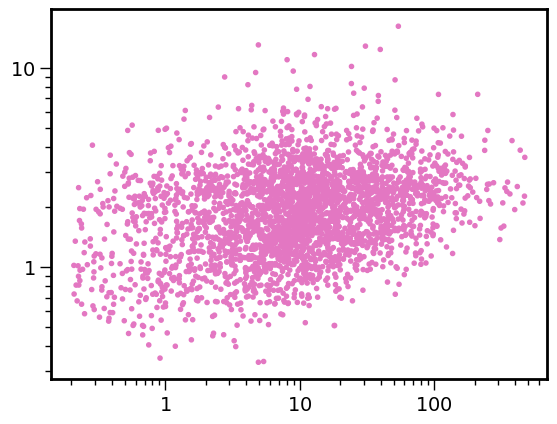

In [6]:
## Distribution of the simulated Data
simulated_periods = epos.synthetic_survey['P']
simulated_radii = epos.synthetic_survey['Y']
plt.xscale('log')
plt.yscale('log')

plt.scatter(simulated_periods, simulated_radii, ls='', marker='.', color='C6')
print(simulated_periods.shape, simulated_radii.shape)

In [13]:
#storage and load

combined_array = np.concatenate((simulated_periods, simulated_radii))
# Specify the file path where the 2D array will be stored
file_path = "/Users/hanzhitan/Desktop/gsoc/p_r.npy"
np.save(file_path, combined_array)

combined_array_loaded = np.load(file_path)
print("Combined array loaded from:", file_path)
print("Combined array:", combined_array_loaded)

Combined array loaded from: /Users/hanzhitan/Desktop/gsoc/p_r.npy
Combined array: [ 9.40419719 36.6125478  16.78788205 ...  1.27792703  0.54257975
  1.94724578]


### Final Input Data
I generate the final spectrum for the training purpose using the period and radius data generated in the previous section. Most other parameters are set to be default values for simplicity purposes (eg. the star, other metrics except H2O ratio of the atmosphere.) I use a uniform random generator to create H2O ratio in a reasonable range (1% to 100%) and don't take the atmosphere type distribution into consideration.

In [140]:
def period_to_semimajor_axis(P_days, star_mass_Msun=1):
    """
    Convert orbital period in days to semi-major axis in astronomical units (AU),
    given the star's mass in solar masses.
    
    Parameters:
    - P_days: Orbital period in days.
    - star_mass_Msun: Mass of the star in solar masses.
    
    Returns:
    - a: Semi-major axis in astronomical units (AU).
    """
    # Convert period to seconds (ignoring units for the computation)
    P_seconds = P_days * 24 * 3600
    
    # Convert star mass to kilograms
    star_mass_kg = star_mass_Msun * M_sun.value
    
    # Calculate semi-major axis in meters
    a_meters = ((G.value * star_mass_kg * P_seconds**2) / (4 * np.pi**2)) ** (1/3)
    
    # Convert semi-major axis to astronomical units
    a_au = a_meters / u.au.to(u.m)
    
    return a_au


In [141]:
def generate_model(P_day, radius, h20_ratio):
    """
    Convert orbital period in days to semi-major axis in astronomical units (AU),
    given the star's mass in solar masses.
    
    Parameters:
    - P_days: Orbital period in days.
    - radius: radius of the planet in meter.
    = h20_ratio: ratio of H20 in the atmosphere
    
    Returns:
    - model.spectrum: object including (Rp/Rs)^2 and wavelength micrometer
    """
    Rp = 1.807 * 6.9911e7 * radius * u.Unit('m')
    g0 = 6.67384e-11 * 1.183 * 1.898e27 / Rp**2 * u.Unit('m3*s-2')
    star = p3.Star.fromSolar(temperature=6460.0, radius=1.458) # radius is in sun radii
    semi_major_axis = period_to_semimajor_axis(P_day)
    
    orbit=p3.CircularOrbit(a=semi_major_axis*u.au)
    planet = p3.Planet(surface_gravity=g0, radius=Rp)
    grid = p3.Grid3D(n_vertical=100, n_latitudes=1, n_longitudes=1)
    input_atmosphere = p3.InputAtmosphere(grid=grid,
    
         # Feel free to add a 1D temperature profile here instead
         temperature = 2000,
    
         # bottom and top pressures
         max_pressure = 1e6, min_pressure = 1e-4,
    
         # Again, you could add more complex molecular profiles if needed
         gas_mix_ratio = {"H2O":h20_ratio, #ratio to simulate
                          "H2":"background"
                         },
         # molecules for which we will not compute the opacity
         transparent_gases = "H2")
    observer = p3.Observer(0, 180) # latitude, longitude in degrees
    rays = p3.Rays(n_radial=100, n_angular=1) # in 1D cases, only 1 angle is required
    opacity = p3.Opacity(rayleigh=True, cia=['H2', 'H2O'])
    
    model = p3.Model(n_vertical = 100,
                     planet=planet,
                     star=star,
                     orbit=orbit,
                     observer=observer,
                     input_atmosphere=input_atmosphere,
                     transmission=p3.Transmission(rays=rays),
                     opacity=opacity,);
    
    model.build();
    model.run();
    return model #.spectrum

In [142]:
# m = generate_model(simulated_periods[0], simulated_radii[0], 1e-2)
# plot = p3.Plot(model=model, label="1D", interactive=True, out_folder="outputs")
# plot.plot_spectrum()
# print(model.spectrum) #(Rp/Rs)^2 vs wavelength micrometer

In [144]:
file_path = "/Users/hanzhitan/Desktop/gsoc/p_r.npy"
combined_array = np.load(file_path)

# Assuming the combined array is 1D and the original arrays were of equal length,
# split the combined array back into two arrays.
n = combined_array.shape[0] // 2  # Assuming combined_array is a 1D array

# Splitting the array into two parts
simulated_periods = combined_array[:n]
simulated_radii = combined_array[n:]

In [ ]:
# Generation of the Input Data
import random
r_ratio, wls, H20_ratio = [], [], [] #shape - [n, 1538], [n, 1538], n
for i in range(len(simulated_periods)//4):
    try:
        ratio = random.uniform(1e-2, 1);
        m = generate_model(simulated_periods[i], simulated_radii[i], ratio)
        r_ratio.append(m.spectrum.value)
        wls.append(m.spectrum.wls)
        H20_ratio.append(ratio)
    except:
        continue

pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 229143468.99505222
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2051623817357497
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.853919876294369
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_sol = 0.9999999999999999
pytmosph3r.Model - INFO - Setting star.radius = 1014330600.0
pytmosph3r.Model - INFO - Setting star.radius_sol = 1.458
pytmosph3r.Model - INFO - Setting star.temperature = 6460.0
pytmosph3r.Model - INFO - Setting star.verbose = 0
pytmosph3r.Model - INFO - Setting input_atmosphere.aeros

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 171833926.99249366
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.403540633812086
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.075033491914781
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 148478713.96838826
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.076857745879095
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.7971733925382605
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 225057003.8370098
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.148002627385019
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.9585007083587036
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 357805981.7776843
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.004839447458236
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.170473403408047
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 416879288.3072797
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.831131991093824
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8622557632258746
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 306113754.1089794
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.281790327714701
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5991568265265925
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 733957858.3009888
pytmosph3r.Model - INFO - Setting planet.radius_jup = 10.266293547543624
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.2781726922966217
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 406481554.5684943
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.685692868691522
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9069326930786187
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 201917656.73046377
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.824339181033735
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.67542993479677
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 692973304.9870532
pytmosph3r.Model - INFO - Setting planet.radius_jup = 9.693018869063016
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.31204967427100794
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 113234745.55579232
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.583879952383376
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 11.686846132294152
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 211540780.9298307
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.9589433912861676
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.348640586830359
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 319508741.035164
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.469153765948134
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.467882373181246
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 227320498.02576455
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.179663431233768
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.8998767874528366
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 320785784.13663584
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.487016507254459
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4562184037912442
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 441141832.3141112
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.170506242853902
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7700169015148463
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 219321747.95727566
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.067780282510989
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.1152531680078317
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 247564853.85404366
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.46283295828965
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.444999446773757
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 245607511.31108287
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.435454474781554
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.484125049850563
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 250860981.4390302
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.508937803377024
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.3811705864145924
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 294184291.6959298
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.114926029428885
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.731481216437246
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 131223062.58142714
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.835492958392927
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.70234715936874
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 291792566.00216573
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.0814715772697046
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7599822868984047
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 304772980.74480057
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.26303615432217
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.6132579657214579
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 137908382.11398157
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9290043936941415
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.879078297162994
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 255351421.03118122
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.5717481820508756
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.2981595968712014
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 775043974.6021929
pytmosph3r.Model - INFO - Setting planet.radius_jup = 10.840988846335154
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.24946180173782986
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 201994513.19865912
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8254142169565704
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.672633553655547
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 130680624.97708336
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.8279055695334212
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.774741630759477
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 269676790.15815955
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.7721254148458505
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.0604856896415518
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 222945978.55164102
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.1184744943719718
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.014792715209306
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 311697121.7075508
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.359888123252263
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5423791986986561
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 334508473.12310725
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.678963703954389
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3391909241401803
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 480228131.0611643
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.717228935561521
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6497728332362911
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 113463299.40553245
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.587076867419186
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 11.639810950674013
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 262967441.49291617
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.6782778701521313
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.1669694134439306
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 179511680.11559504
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.5109338123929255
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.650196660969318
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 346322913.4192251
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.844219121289446
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2493792554920817
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 441815437.99634314
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.179928355569058
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7676707075529201
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 144782350.39966512
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.025154568338627
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.148674089905349
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 169531377.91840628
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.3713335466682466
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.213826312878093
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 234806806.49416026
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.284378762577075
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.71791192687794
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 335593548.29698426
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.694141278702292
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3305449079100504
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 332980905.76099443
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.657596734753461
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.351506325413051
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 477308666.60361093
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.676392695736738
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.657745829759669
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235987675.91489038
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.300896266923437
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.6907794167469934
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 97620653.96347834
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.3654766122570126
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 15.72437230147376
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 269784735.7114211
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.7736353118030137
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.0588371473690215
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 328383734.8835859
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.593293443792114
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3896117166883237
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 199994435.33943468
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.797437969834872
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.7464584404351617
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 286915517.8534492
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.013253480857288
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.8203238857882946
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 168259248.70979473
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.3535395388266482
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.292962931040066
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 163838012.39342433
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.2916971464419
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.582482906753167
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 162385978.97450116
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.27138671424077
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.682764876337056
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 175734889.2765304
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.458105652052403
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.852223078381072
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 242398475.29567313
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.3905678299064665
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.5503335009139954
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 187251300.49629465
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6191923641287786
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.273729769714009
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 196667808.34629118
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.75090651186554
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8742727076532244
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 174506867.05364084
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.440928594159358
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.920754519414674
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 264895336.48296148
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.705244453686587
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.1355420049915526
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 152238806.78793314
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1294523413519433
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.465557829714153
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 220626535.24547872
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.086031097821836
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.0785148557614286
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 209633726.9885087
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.9322683235677935
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.409843385242774
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 222071785.08362982
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.1062466441508114
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.0385751105418177
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 215085725.2940353
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0085285807367996
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2391686962742674
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 99887063.82252246
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.3971781992743588
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 15.018904259317104
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 108074635.20485324
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.5117025010470155
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 12.82948391884514
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 313414397.7435277
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.383908657521508
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.525523339906805
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 103253411.04641098
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4442652471103197
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.05555269683165
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 410279168.6006323
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.738812295090812
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8902209483776125
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 343884525.52069855
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.810111977853445
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2671600619160381
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 218040144.8309504
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0498537574966487
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.151982659966049
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 164423155.94837928
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.2998818881606233
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.542820105925875
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 154574309.3905763
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1621203685807684
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.271654329786946
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 111847537.79818362
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.5644762742430427
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 11.978539994751007
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 196677016.99356037
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7510353185469754
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8739099202150187
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 394815067.9177952
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.52250696466451
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9613229387350332
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 182476168.25953186
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.5523998245892106
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.500330796196108
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 289142191.4532936
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.044399253808728
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7923953424840722
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 370238190.12060237
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.17873594417001
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0931866382310966
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 322599562.58458716
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.512386876637765
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4398896000334624
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 88317634.44020675
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.2353498914592786
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 19.21152707093939
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 171635878.49164724
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.400770414754759
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.086752284878572
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 431772690.26019317
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.039454627933099
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8037970427615804
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 207777190.7456399
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.906299876148938
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.47105106660653
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 338864286.69018
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.739890990462989
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3049838661788333
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 140373359.14403495
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9634834547087079
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.604792310746207
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235356217.8300115
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.292063697057174
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.7052374479428676
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 431340160.99211633
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.033404590613164
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8054098768546502
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 414804856.30269164
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.802115709487658
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8709015807980917
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 144261239.27498674
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.017865485298869
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.20041330872904
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 427598236.8356707
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.981064130751283
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.819567884356141
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 454024382.4525829
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.350701931021413
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.726939705220577
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 375346583.68059427
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.2501900028058275
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.063633013179428
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 119525934.77112007
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.6718784587243336
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 10.488960395684034
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 173457867.8058542
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.426255634278719
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.980451738606501
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 243955134.4780063
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.412341723241849
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.517890372088207
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.2453339999999994e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143538
pytmosph3r.Model - INFO - Setting planet.radius = 175454979.6810006
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4541903944637244
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.867717277306893
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 176635770.47220355
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.470706798973361
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.8028544903307715
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 149616733.4569627
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.092775883413007
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.694164894636268
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 103295926.33067505
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4448599330089387
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.04398490587746
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 173581167.98371926
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4279803052609976
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.973378707719632
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 174155127.88371557
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4360086147221445
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.940651377947374
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 153704701.79110944
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1499566635582923
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.342820745300542
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 327871537.8759248
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.586129047668617
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.393956777655019
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 289031007.57926023
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.042844060583844
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7937745978796322
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 219236951.64915094
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.066594187449658
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.1176634647367356
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 212852767.19166106
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.9772949028095597
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.3074869713055643
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 143354586.43647057
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.005183607067512
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.291780031198525
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 170187225.87921304
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.3805072718515783
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.173718854244089
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 229405152.96565637
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2088227069554125
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.847412619406576
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 247526073.52630562
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.4622905153906114
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.4457656311692264
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 88543716.5895892
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.2385122333909975
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 19.11354522796816
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 275010290.22190577
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.8467281684930588
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.9813393029315023
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 284165249.8995073
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.9747838904983395
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.8557300823142118
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 363579984.7591508
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.085603770479925
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1335920959295416
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 202310675.22349295
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.829836558265162
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.6611636698725487
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 296966227.27086043
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.153838573139098
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.699192646930357
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 558636169.9159567
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.813967575616247
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.4801739997524426
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 172491217.52721784
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.412734537112094
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.036429603282334
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 338050556.89613146
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.728508880659814
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3112739449784154
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 487254563.6919623
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.815511717282525
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.631167913063358
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 357748901.7363224
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.004041035868662
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1708469391471583
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 137325237.3881854
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9208476107562442
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.946136596147284
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 42299387.31557751
pytmosph3r.Model - INFO - Setting planet.radius_jup = 0.5916660229896702
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 83.75072774910016
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 115599154.61525871
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.616952310961488
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 11.213661112231886
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 298006444.4877753
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.168388693668876
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.6873509930213162
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 242920270.83825102
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.3978664862956838
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.539388976504764
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 290440340.8828524
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.062557221547199
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7764086026992085
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 188632350.67413688
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6385099126354956
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.211379605838597
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 1192697620.7528217
pytmosph3r.Model - INFO - Setting planet.radius_jup = 16.682952228960186
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.10534066059101575
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.m

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 159883056.9037449
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.236376893970583
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.862081564358062
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 191636047.97179925
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6805243659682096
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.0803961702838425
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 119864054.6744634
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.6766079375939043
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 10.429868048858756
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 360152096.4173028
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.037655911392922
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.155273599983652
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 1212641119.852918
pytmosph3r.Model - INFO - Setting planet.radius_jup = 16.961913498753958
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.10190421826155319
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 460281900.00089896
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.438229452258979
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7073086169267799
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 317643478.0859015
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.443063253033927
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4851723588614265
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 358859026.531581
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.019568994175306
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1636141502887756
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 223125121.4658723
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.120980270042414
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.0099536191919483
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 259496084.11643744
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.629721984507881
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.2253336041062446
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 180015835.95649928
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.51798573206092
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.624186272759273
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 148695884.61421317
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.0798954374505283
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.7773333198726275
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235227146.0290447
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2902582950406294
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.7082070513417715
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 442048271.17173576
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.183185128010627
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7668622341444967
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 167339100.61392406
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.3406688946165173
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.351331835130356
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 381793987.18688315
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.340373568887192
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0280129234725632
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 216016637.66792452
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.021549791136414
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2113107966497645
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 141999850.52723828
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9862341314725882
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.431576775333886
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 103316124.18911903
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.445142452150157
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.038494365183194
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 105788508.98861767
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4797251299252736
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 13.38997453500012
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 310452430.03780913
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.342477900153991
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5547716610401447
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 96269898.28830905
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.3465828105006021
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 16.168722870359765
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 375927243.5351771
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.25831202841125
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.060349760795954
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 201496382.32056814
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8184465719320784
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.690814659472346
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 154204253.12457824
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1569441773146396
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.301791627797709
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 354038032.5666588
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.952134960088664
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1955201654731704
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 317665886.0657185
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.443376686422515
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4849628397412729
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 152429704.21285436
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.132122534169618
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.449373510829795
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 392746791.5195857
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.493576785089041
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9714746034478997
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 255347143.9667091
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.5716883562735564
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.298236585859066
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 205561019.80749324
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8753010100080183
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.546297910061307
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 140874467.60633692
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9704927489276691
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.550786101548125
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 258836483.67438596
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.620495771196581
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.236689818393286
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 189503202.37725487
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6506910196561133
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.172762208484412
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 285687696.5764618
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.9960792337109297
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.836004191642304
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 211410601.31436193
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.957122493626726
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.352765819483817
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 1049666247.0100795
pytmosph3r.Model - INFO - Setting planet.radius_jup = 14.682289584989642
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.1360048133363978
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 212276426.58014554
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.969233292957891
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.325471321799037
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 306337882.16695404
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.2849253366384215
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5968176786793755
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 192997695.75310582
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6995705219200166
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.023022815078008
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 343899597.01322347
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.810322791546235
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2670489970873522
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 193735264.19915807
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.709887318849075
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.992449069105721
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 295484306.3561458
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.133110087228582
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.716279060060407
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 121420153.15204188
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.6983739880272182
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 10.164246541276698
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 173952989.37394544
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4331811863417645
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.952140414927928
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 355498234.67107075
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.972559652423638
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1857191837806695
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 91661745.22529109
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.2821259053501242
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 17.835303314407067
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 96777386.23466152
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.353681338256889
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 15.999594147681417
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 209375097.99081326
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.928650730023125
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.4182725542889223
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 185991813.62999934
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6015751920494505
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.3318068596115795
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 213453349.71695703
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.985695598346067
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2889009492188372
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235094384.05394122
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2884012764217143
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.7112666602715065
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 113472878.67992415
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.587210858276788
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 11.637845789697076
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 137903754.41622055
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.928939663405983
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.879607109521073
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 267961740.21542224
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.7481360182317216
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.086945771301601
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 408432004.19521934
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.712974936989024
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8982913388364175
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 296441292.3411556
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.146496004324338
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7052157978008582
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 382442887.9217097
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.349450119198088
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0245273707902218
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 312696589.843373
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.373868262789864
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5325351819748054
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 110980354.81161082
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.5523464836850391
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 12.166468202129906
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 413251722.8174929
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.780391132119578
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8774601412886781
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 175648818.0668466
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4569017242047586
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.856979603810771
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 360278157.29018056
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.039419197814868
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1544652838714258
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 297083817.8998479
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.155483381355228
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.6978477767204876
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 294952174.428471
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.12566684983594
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7224774258147724
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 171328885.9831725
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.3964763327809053
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.10499782348035
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 240810875.39632466
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.368361150846593
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.58407164397194
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 91226860.48569031
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.276042920686095
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 18.005752864196005
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 297584198.0218716
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.162482487856986
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.6921428030090693
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 200720999.12400115
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8076008381917017
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.7193848960198297
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 439709453.86104727
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.150470736041057
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7750418200319513
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 101611962.7343077
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.421305359121408
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.513329750173575
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 241780838.9475046
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.381928592674769
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.563379949072386
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 349481287.2757434
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.888397125213219
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2268992185942518
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 326006138.76107717
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.560036630127527
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4099547900521736
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 373549574.15063643
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.2250541899882
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0738911219564167
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 370972506.30338657
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.189007249809581
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0888631364352765
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 202632807.03826985
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8343424024823736
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.6495323859989695
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235331633.7583795
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2917198254123465
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.705802686231684
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 188458505.71076825
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6360782424714406
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.2191528268840575
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 137395307.39416376
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9218277205024863
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.93803378867578
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 170736220.29481566
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.3881863746267507
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.140500638933609
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 440850196.7039301
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.166426966708584
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.771036016981389
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 276257455.64280766
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.864172993381185
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.9634901552261559
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 252138772.7139851
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.5268110098190717
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.357097103313402
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 88439627.5171458
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.2370562792640547
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 19.158563101244308
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 171918890.5515596
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4047290683091758
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.07001849493403
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 437141715.39561784
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.11455429132795
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7841736392476814
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 319309118.89701134
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.466361535514621
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4697182957691808
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 198111287.08833137
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7710972848476945
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.818020925238696
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 174237049.62670726
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4371545015765017
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.936006537799497
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 430339196.199435
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.019403516469465
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8091609854174971
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 311636753.7815273
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.359043722116143
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5429768127511971
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 515581964.3666961
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.211743472929784
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.5637172305142502
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 154706435.17457
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1639684884262573
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.260946392595121
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 145030631.73284227
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.028627423108072
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.124219075388804
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 801291090.6235318
pytmosph3r.Model - INFO - Setting planet.radius_jup = 11.208122455988526
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.23338670651297055
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 226051424.58918056
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.1619121662449023
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.9325285345092755
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 433528124.8224453
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.064008907604281
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7973007796387523
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 134761343.00921893
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.8849849355063353
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.251370392453055
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 643389649.9888343
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.999463576188024
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.3620000268766187
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 135990551.25918818
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9021785830468887
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.102877528295599
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 233574768.21443623
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.26714552977167
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.7466599198741677
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 335223816.9102795
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.688969631710954
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.333481545948573
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 190209227.0341968
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6605665953420914
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.141842516639118
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 262568950.94420248
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.6727039521093614
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.1735518527630675
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 386480105.3366009
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.40592101684945
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.00323449770836
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_so

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 262514706.7670389
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.6719452073943786
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.174450200246141
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 128961821.9729189
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.8038636766759761
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.010199828084994
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 105677963.32449424
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.478178863711943
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 13.41800266448139
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 514239202.6073629
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.192961486702888
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.5666649878228496
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 388744383.8507495
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.43759279151163
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9915816644822637
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 136786085.90343115
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9133061867541983
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.008900502126902
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 136838572.190441
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9140403428417305
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.002757835965381
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 448857563.1156965
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.278430637213905
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7437716981845605
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 479804610.86639416
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.711304913366448
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6509204394311857
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 453777372.3719718
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.347246857997702
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7277313282389841
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 204159959.81753054
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.855703572672894
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.5951382869381114
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 350743643.96925384
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.906054439227519
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2180836784532045
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 352814335.962676
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.93501840713193
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.203827600076897
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_so

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 138941451.12310633
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9434545281025335
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.762347525871021
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 379370007.92587435
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.306467967407183
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.041191840501372
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 939360871.125049
pytmosph3r.Model - INFO - Setting planet.radius_jup = 13.139384422383609
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.16982116337842318
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 294330692.7027756
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.1169738250821855
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7297591564808958
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 296247344.24993175
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.143783140070662
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7074492801594465
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 333929628.3235643
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.670867066574782
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3438377449127006
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 209391449.31871673
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.928879445514417
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.41773871097074
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 238209094.33705664
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.331968532661789
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.64082770424459
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 433927850.1830533
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.06960009767601
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7958325422302629
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 173479369.24482468
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4265563873555736
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.979217237428983
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 452642571.59380585
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.331373742430004
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7313848302781509
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 186985790.44142428
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.615478521253067
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.28587533268198
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 387300032.1912468
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.417389808527482
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9989912334448133
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 245034777.12235865
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.427443310053693
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.495751204249308
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 286840772.7644862
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.012207978018326
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.821272690916621
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 134789093.44442126
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.8853730969118399
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.24797315099387
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 190398776.5598185
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.66321793431179
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.133599884967298
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 102065449.08385076
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4276485352745867
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.384648092251513
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 333029923.0820775
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.65828236840594
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3511085092435247
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 109339296.5845941
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.529392052042104
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 12.534418535404551
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 207801651.92590085
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.906642028841001
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.4702339315382362
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 301450334.5088049
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.216560377508041
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.6490172664296738
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 270423891.8907061
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.782575559373162
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.0491163836719255
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 565074072.1809534
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.904018242334154
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.46929505934702986
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 313817357.88572866
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.3895450943564125
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5216081298984603
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 151604918.37512672
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1205857770817254
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.519738266732183
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126495991.38942963
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.769372676515269
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.364901570510558
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 381962038.4794369
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.342724199622851
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.027108535711959
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 157902324.48447922
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.2086712427191744
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.010072302121537
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 331042279.11984074
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.630480041401006
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3673818679524528
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 215100266.7943624
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.008731981121837
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2387307537164167
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126214697.77286485
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.765438059822985
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.406691038529049
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 192620381.58483687
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.694292810172283
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.038799237133322
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126840322.94649263
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7741890413821493
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.314125064500917
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 233992131.7586709
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2729834353308185
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.7368704166703797
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 191609100.8273416
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.68014744065548
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.08154395247571
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_so

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 803687140.2508436
pytmosph3r.Model - INFO - Setting planet.radius_jup = 11.241637389509926
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.2319971793783255
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235251160.95116398
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.290594205661668
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.707654160877103
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 493269748.6160477
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.89964959178716
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6158681995490564
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 151909906.1844933
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1248518181683727
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.493585336268252
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 197895456.5810493
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7680783385700396
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8263535547110363
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 211641448.67667526
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.9603514893509097
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.345455767091578
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 102334402.0788173
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4314105365469882
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.309136628498704
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 350467655.30607563
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.90219402598998
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2200028835413577
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 315536479.53197026
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.413591444245093
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5050730932489944
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 342138037.1268552
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.785682833419895
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.280129849426653
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 203513652.6849741
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8466633005787236
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.6180090182859597
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 443347763.9551461
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.201361886017262
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7623733360063658
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 219844843.45106944
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0750971220705736
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.1004460324322203
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 422348511.4630292
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.907633182216601
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8400687074300227
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 265877897.05908355
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.7189880973966813
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.119787237570227
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 249073941.1034374
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.4839414354534406
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.4154617130562377
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 399898700.0028538
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.593614670212804
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9370370405602788
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 199571672.65460172
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7915245433699116
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.762347873998978
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 272067053.3522858
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.805559410175765
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.024439662494294
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 214703088.05186412
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0031764120721776
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2507244780014357
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 472572382.81835914
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.610143551982866
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6709962107938703
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 322326300.44194967
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.5085646008217655
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.442332057281305
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 92308868.39160733
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.291177591781001
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 17.58611420967971
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 178618478.38932732
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.498440082657183
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.69682060383395
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 313915944.0190266
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.3909240756871615
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5206525498500767
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 252088386.57457396
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.526106229712051
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.358039446544205
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 327643130.9833023
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.582934188207104
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3959009680491072
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 64182373.34985959
pytmosph3r.Model - INFO - Setting planet.radius_jup = 0.8977560195526714
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 36.37685913419769
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 151566862.9689106
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.1200534740797656
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.523012629362541
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 83660053.96074131
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.1702016164150018
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 21.410187101580803
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 780467640.5737071
pytmosph3r.Model - INFO - Setting planet.radius_jup = 10.916852802743064
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.2460067031399123
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 249287032.82912472
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.486922072807093
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.4113339819940185
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 77099611.71663335
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.078436912054962
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 25.208810959603742
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 258559163.573135
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.6166167343637747
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.2414903575150595
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 121619118.300745
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.701157028768883
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 10.13101695340991
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 400442011.6167208
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.601214284349588
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.934496059736054
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 226385424.53541756
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.1665840168888484
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.9238818484983655
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 145502719.96977633
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.035230794631236
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.078064557850199
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 181749396.6228565
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.5422340488845814
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.536394213535792
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 485089842.9087636
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.785232514250036
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6368136749422468
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 195539196.52132353
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.735119964769814
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.919124776153019
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 280600305.39057463
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.9249189474427157
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.9031826267826641
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 102278143.08390775
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4306236094095528
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 14.324882691616232
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 173887817.01909435
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4322695828777254
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.955853189510523
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 1467005903.527912
pytmosph3r.Model - INFO - Setting planet.radius_jup = 20.51986101281139
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.06962945890004314
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 321026870.93838626
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.490388727946991
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4540320247488185
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 406093793.2201309
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.680269026186579
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9086655013543216
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 210107705.4091332
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.9388981341847087
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.3944763218705862
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126652025.35690841
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7715552139667152
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.341840863425817
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 293207835.3676094
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.101267769367333
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.743032961259216
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 444738694.38182044
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.220817635285353
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7576121130349119
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 246888907.90872186
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.453378110959574
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.458405880342673
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 344878408.42327386
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.824013993499606
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2598670914942522
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 246240690.93441656
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.4443111248030065
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.4713661910684492
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 103897959.92863087
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.4532809255389536
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 13.881701550369668
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 264931459.37018275
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.70574972542638
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.134959690727257
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 346491666.24993503
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.8465795648455074
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2481625743165998
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 367299739.3854413
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.137634132286707
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.110747905317595
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 214651490.72082406
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.002454690326527
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.25228746613191
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 225796943.49962667
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.158352591893172
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.9391423848388305
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 294246581.7750054
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.115797316832728
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7307482075082392
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 231137520.14740837
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2330543298188377
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.8048900663487553
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 162593383.2925296
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.2742877985303194
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.668276239482042
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 225721936.56739125
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.1573034265007447
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.9410960512443918
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 203820788.66467702
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.85095938936772
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.6071133338302084
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 369768463.85755897
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.172165610943307
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0959658077908598
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 207211636.77404425
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8983891452756145
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.4900243800673447
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 349860695.665328
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.8937041300471105
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.224239626032526
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 198530825.45097256
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.77696561085118
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8019013754086264
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 607336541.9929727
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.495167878825221
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.40625425112302815
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 166496428.79942167
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.328881956014962
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.40563724060641
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 356039196.0891738
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.980126393011439
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.18211878781779
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 380405935.48016304
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.320958085941966
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0355287811906744
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 206818737.13931248
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.892893430584016
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.5032971792868683
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 219742400.5782292
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.073664194290678
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.103337532970673
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 108655123.35007875
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.5198221248542318
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 12.692767501074677
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 187094896.66930756
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6170046532382303
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.280878089553428
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 107724511.17494206
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.5068051135083933
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 12.913015704152581
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 211396193.23652086
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.9569209594992567
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.353222862313127
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 329418649.9288507
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.607769399776908
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3808941105115813
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 418484466.53736013
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.853584548444023
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8556537512132492
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 196712404.67080227
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7515303064790784
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8725162476265305
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 311991157.1060023
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.364000966625668
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5394733447009394
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 614502346.0122782
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.595400128857468
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.3968347110548414
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 190589213.68739316
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6658816886839527
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.12534340925128
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 458898591.6909991
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.418880317951646
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7115792797415459
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 785027487.0332559
pytmosph3r.Model - INFO - Setting planet.radius_jup = 10.980634015459854
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.24315713429794944
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 424153152.5489143
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.932875742025881
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8329354472348124
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 353596805.1843669
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.945963257208735
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1985056299184278
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 248110320.42569426
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.4704627150687384
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.4342606799015507
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 308951312.45097864
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.321480899275144
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5699168628727793
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 337633259.595768
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.722671901692049
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3145172820116866
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 117248855.79987802
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.6400276366569408
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 10.90032675477739
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 130849362.96261217
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.8302658054413383
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.752125127148998
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 475943089.50851345
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.657291578197748
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6615256564741075
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 174856030.69380543
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.4458125481705006
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.901121989734132
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 406656618.76593256
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.688141592988482
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9061519986969017
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 440320224.62459415
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.1590139403652735
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7728931811614369
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 576098592.3269162
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.05822458914167
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.4515055729588103
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 365680277.51456404
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.114981781382029
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1206078684073213
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 358684218.38985634
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.017123851477876
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1647486233632471
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 158344607.54673344
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.214857712006007
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.9765449103231925
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 476021036.49742454
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.658381867865279
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6613090286054283
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 197258435.08121595
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7591679499974253
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8511069218465366
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 439371285.4772019
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.145740579046633
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7762353231615381
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 263810769.23701486
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.690073983620753
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.1531371920412985
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 358444190.65690607
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.013766444593886
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1663090647640253
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 585385226.8716674
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.188122123757447
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.4372937064973586
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 327987674.5204496
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.587753518162166
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3929697844613738
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 289588585.8219734
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.050643230319104
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7868737263252419
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 386932522.89117575
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.412249243148544
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.0008898224841474
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 290033724.15768015
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.0568696379690055
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7813930146470485
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 53757854.73212045
pytmosph3r.Model - INFO - Setting planet.radius_jup = 0.7519422415391994
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 51.852880198836665
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 91976159.9336075
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.2865238059308384
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 17.71357401107266
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 204793157.67466578
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8645604777410867
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.5729411135170075
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 235327558.77308404
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.2916628262334813
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.7058963956270605
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 296328490.9876062
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.144918186476896
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7065142707209078
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 451015881.01856744
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.308620279451791
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.736670153423611
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 610435350.4372606
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.538512706837976
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.4021401094424914
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 292777316.51423955
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.095245852881995
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7481628687645936
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 84427448.67000012
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.1809356105578264
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 21.022744513553437
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 184181111.13330856
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.5762478477774935
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.417398363676798
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 345117683.76112205
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.827360876197645
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.2581207270717378
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 96610757.59319901
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.3513506069658006
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 16.054832089633326
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 97671892.0202809
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.3661933086258726
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 15.707878816284866
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 141905143.6265274
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.9849094112142252
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.441499692144294
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 197243707.29366
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7589619439050526
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.8516820520030115
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 310586239.68760115
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.34434957320541
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.5534322672790233
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 150097185.12554502
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.099496239097312
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.651378279721119
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 252241128.0177933
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.5282427127202105
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.3551845489091514
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 218304788.71259496
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0535554847059103
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.1443451974758334
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.2453339999999994e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143538
pytmosph3r.Model - INFO - Setting planet.radius = 540858647.9749359
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.565303082511831
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.5122585158889476
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 338118862.7440529
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.729464314105814
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3107441985405297
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 636453486.9809428
pytmosph3r.Model - INFO - Setting planet.radius_jup = 8.902443447951418
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.3699332797420888
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 161090583.95445767
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.2532672740230746
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.774527203465255
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 268488162.5283419
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.7554993919367465
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.078770082753856
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission
pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 259809117.97319603
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.6341005703183016
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.219974399547395
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 411290641.0447722
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.752960345839705
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.8858477549901216
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 557122981.2307001
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.7928017292941885
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.48278592074720306
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 300732346.2734672
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.206517460323773
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.6569006109507862
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 253452745.94316056
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.5451903142052337
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.3327206919841568
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 87758751.53030497
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.2275324725886108
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 19.45699963536655
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 276662928.8926394
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.8698445825076844
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.9577390462524453
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 221315793.8431425
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0956721569286425
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.0593694651943344
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 289078950.50619143
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.043514666063215
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.7931796623231189
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 218421591.12990275
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0551892677488772
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.140983177093758
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 213787024.05070007
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.990362894459521
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2786424649045682
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 323905698.76844496
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.5306565597331865
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4283004244878044
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 188097748.3612951
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.631032120535096
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.235352383036421
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 326472172.5950029
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.566555315210134
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4059322870566542
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 254328127.129078
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.5574347777244726
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.31669017599023
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_s

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 215238335.67442966
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.010663230493337
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.2345769908260267
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 360224832.3678868
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.038673311250025
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1548071055482654
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 271095807.4480629
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.7919740313330568
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.0389714320566554
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 191768901.36913165
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.6823826633627768
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 4.074744506076828
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 150882925.87441525
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.110486849919085
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.582282976347956
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 465857824.73572165
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.516223140151648
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6904781728286258
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 199324046.00350147
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.788060846017757
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.77170185147491
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 144074841.10521019
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.0152582261681053
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 7.21905656465979
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 134608230.05292687
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.8828432559297106
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 8.270152457256406
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 82047498.21707404
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.147645865510463
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 22.26004597796067
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...


be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 523003365.49684775
pytmosph3r.Model - INFO - Setting planet.radius_jup = 7.3155509077497864
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.547832478747791
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 124015644.56886555
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7346786293412626
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.743248820693422
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 194386277.6940059
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.718993421557739
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.965751856702555
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 158848156.68265373
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.22190114534009
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 5.9387136373463845
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 355117499.34086215
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.9672340869029
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.1882630583675904
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 338911412.2545649
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.740550163019147
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.3046209759170486
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 200129345.11051652
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.7993250309197744
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.741409071083046
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 316956012.5565692
pytmosph3r.Model - INFO - Setting planet.radius_jup = 4.433447274612114
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 1.4916219103551507
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 122395575.66765468
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7120177875518194
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 10.0028856636852
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 467662587.36606413
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.541467400073632
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.6851591897759741
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 217701287.32325295
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.045113961327882
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.1618025764468993
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 445689090.9431151
pytmosph3r.Model - INFO - Setting planet.radius_jup = 6.234111382296132
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.7543844628357405
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 216061620.34678975
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.0221789899120144
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.209973786171673
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126908097.56489202
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7751370442132268
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.304179399517226
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mas

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 204506655.67122373
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.8605530083257387
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 3.5829590938554383
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.ma

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 238207498.836536
pytmosph3r.Model - INFO - Setting planet.radius_jup = 3.3319462154721644
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 2.6408630805959503
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 704004565.0067421
pytmosph3r.Model - INFO - Setting planet.radius_jup = 9.847319490386926
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.3023470898325767
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 394263113.0797718
pytmosph3r.Model - INFO - Setting planet.radius_jup = 5.514786452746766
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 0.9640164611317131
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 148341916.50367236
pytmosph3r.Model - INFO - Setting planet.radius_jup = 2.074944280530302
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 6.809715563299761
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass

In [161]:
input_features = np.concatenate((np.array(r_ratio), np.array(wls)), axis=1)
print(input_features.shape)
# Specify the file path where the 2D array will be stored
input_features_path = "/Users/hanzhitan/Desktop/gsoc/input_features.npy"
np.save(input_features_path, input_features)
h2o_ratios_path = "/Users/hanzhitan/Desktop/gsoc/h20_ratios.npy"
np.save(h2o_ratios_path, np.array(H20_ratio))

(764, 3076)


## Model and Training

Data: 
* Spectrum - represented as 2D array (n, Radius Ratio/transition depth)
* Value to Predict: a fraction/float (H2O mix ratio)

Model: I use a simple fully-connected network due to the simplicity of the input data and the value to predict, I treat it as a regression problem.

In [162]:
h2o_ratios_path = "/Users/hanzhitan/Desktop/gsoc/h20_ratios.npy"
input_features_path = "/Users/hanzhitan/Desktop/gsoc/input_features.npy"
input_features = np.load(input_features_path)
h2o_ratios = np.load(h2o_ratios_path)

In [238]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

#normalize data, split into training/validation/testing dataset
radius_scaler = MinMaxScaler()
radius_features_scaled = radius_scaler.fit_transform(radius_features)
input_features_scaled = radius_features_scaled

X_train, X_temp, y_train, y_temp = train_test_split(input_features_scaled, h2o_ratios, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [250]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(1538,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])


In [251]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250, batch_size=64)


Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3541 - mae: 0.5164 - val_loss: 0.3300 - val_mae: 0.4925
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3223 - mae: 0.4825 - val_loss: 0.3152 - val_mae: 0.4785
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3039 - mae: 0.4667 - val_loss: 0.2923 - val_mae: 0.4555
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2799 - mae: 0.4502 - val_loss: 0.2660 - val_mae: 0.4297
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2520 - mae: 0.4184 - val_loss: 0.2394 - val_mae: 0.4031
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2450 - mae: 0.4141 - val_loss: 0.2135 - val_mae: 0.3787
Epoch 7/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1955 - mae: 0.3636 - val_loss: 0.1920 - val_mae: 0.3564
Epoch 8/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1762 - mae: 0.3483 - val_loss: 0.1643 - val_mae: 0.3298
Epoch 9/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1506 - mae: 0.3159 -

In [252]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0527 - mae: 0.1307
Test Loss: 0.06778371334075928, Test MAE: 0.14154194295406342


## Results

There're a few outliers but predictions essentially capture the trend and correctly predict the ratio ( <0.5 or > 0.5) after 250 epochs of training. (The loss significantly decrease around epoch 25).

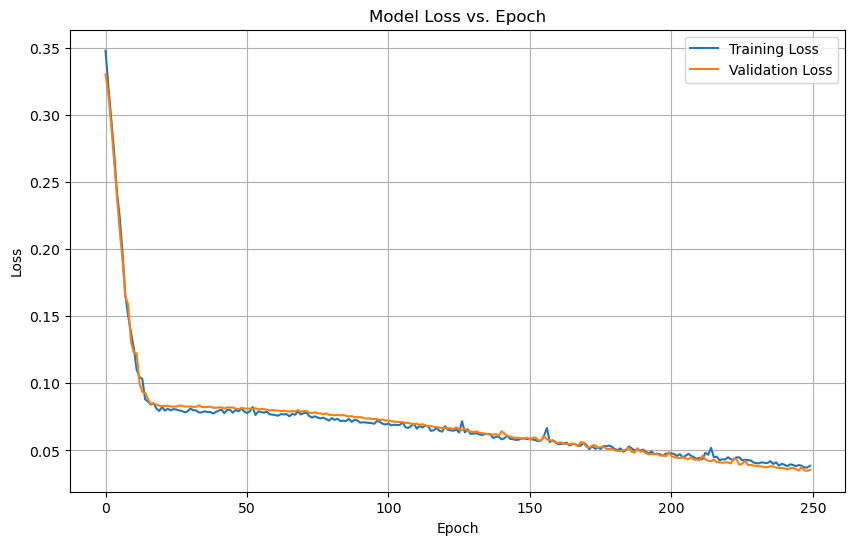

In [253]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


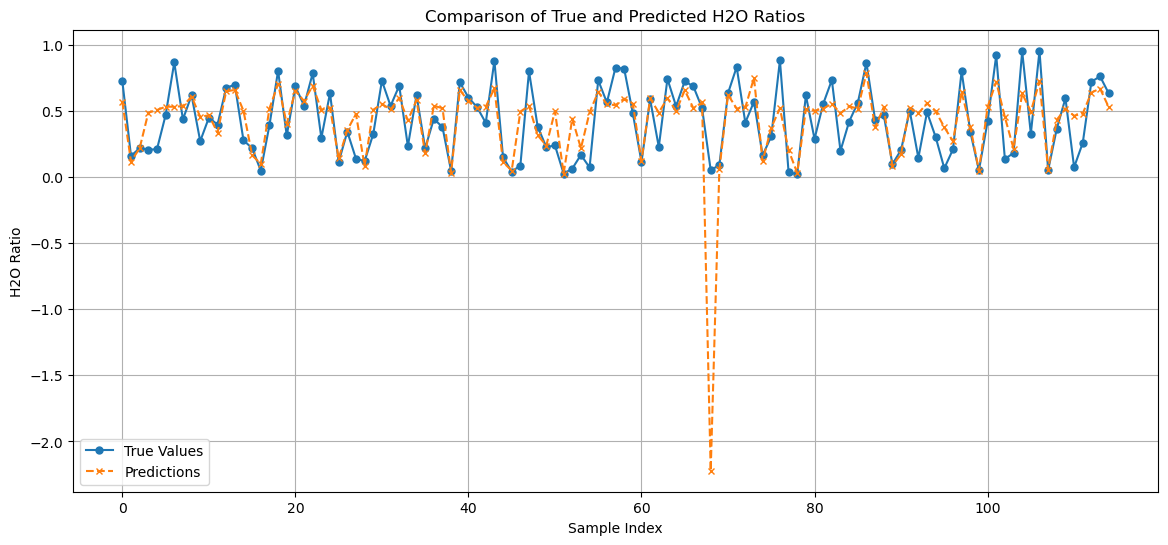

In [254]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
predictions = model.predict(X_test).flatten()

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='True Values', marker='o', linestyle='-', markersize=5)
plt.plot(predictions, label='Predictions', marker='x', linestyle='--', markersize=5)
plt.title('Comparison of True and Predicted H2O Ratios')
plt.xlabel('Sample Index')
plt.ylabel('H2O Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [256]:
model.save('/Users/hanzhitan/Desktop/gsoc/h20_prediction_model.keras')  # Saves the model to a SavedModel directory
